In [1]:
import torch
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from chirho.robust.internals.utils import ParamDict

pyro.settings.set(module_local_params=True)
sns.set_style("white")
pyro.set_rng_seed(321)  # for reproducibility

In [2]:
class ToyNormal(pyro.nn.PyroModule):
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=sd),
        )


class ToyNormalKnownSD(pyro.nn.PyroModule):
    def __init__(self, sd_true):
        super().__init__()
        self.sd_true = sd_true
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=self.sd_true),
        )

class GroundTruthToyNormal(pyro.nn.PyroModule):
    def __init__(self, mu_true, sd_true):
        super().__init__()
        self.mu_true = mu_true
        self.sd_true = sd_true
    def forward(self):
        return pyro.sample(
            "Y",
            dist.Normal(self.mu_true, scale=self.sd_true),
        )

In [3]:
normal_pdf = lambda x, mu, sd: torch.exp(-0.5 * ((x - mu) / sd) ** 2) / (sd * math.sqrt(2.0 * math.pi))
normal_pdf_partial_sd = torch.func.grad(normal_pdf, argnums=2)


def fisher_eif_analytic(Y, mu, sd, known_sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    if known_sd:
        return torch.zeros(Y.shape[0])
    else:
        sd_torch = torch.tensor(sd, requires_grad=True)
        z_monte = sd * torch.randn(10000) + mu
        grad_functional = 2 * torch.tensor([normal_pdf_partial_sd(z, mu, sd_torch) for z in z_monte]).mean()
        inverse_fisher = sd ** 2 / 2
        score = ((Y - mu) ** 2) / (sd ** 3) - 1/sd
    return grad_functional * inverse_fisher * score


def kennedy_if_analytic(Y, mu, sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    pdf_at_y = normal_pdf(Y, mu, sd)
    z_monte = sd * torch.randn(100000)
    expected_density = torch.tensor([normal_pdf(z, mu, sd) for z in z_monte]).mean()
    return 2 * (pdf_at_y - expected_density)

# Analytic Influence Function & Efficient Influence Function

In [4]:
N_pts = 100
mu_true = 0.0
sd_true = 1.0
true_model = GroundTruthToyNormal(mu_true, sd_true)
D_pts = Predictive(true_model, num_samples=N_pts, return_sites=["Y"])()
Y_pts = D_pts["Y"]
Y_pts = torch.sort(Y_pts).values

fisher_pointwise = fisher_eif_analytic(Y_pts, mu_true, sd_true, False)
kennedy_pointwise = kennedy_if_analytic(Y_pts, mu_true, sd_true)
tangent_fn_pointwise = kennedy_pointwise - fisher_pointwise

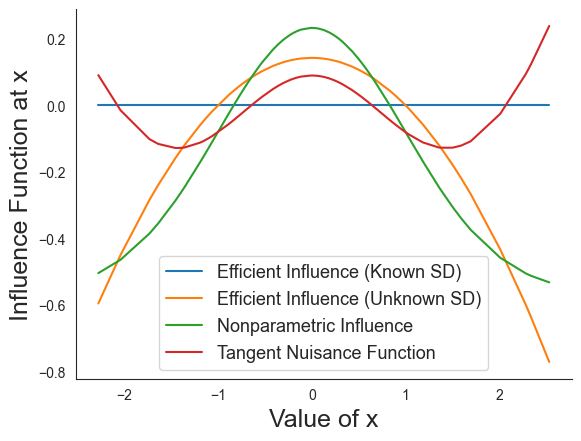

In [5]:

plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label="Efficient Influence (Known SD)")
plt.plot(Y_pts, fisher_pointwise, label="Efficient Influence (Unknown SD)")
plt.plot(Y_pts, kennedy_pointwise, label="Nonparametric Influence")
plt.plot(Y_pts, tangent_fn_pointwise, label="Tangent Nuisance Function")
plt.xlabel('Value of x', fontsize=18)
plt.ylabel('Influence Function at x', fontsize=18)
plt.legend(fontsize=13)
sns.despine()
plt.savefig("figures/toy_normal_influence_functions.pdf")

In [6]:
# This should be close to zero since the tangent nuisance function is orthogonal to the efficient influence function
fisher_pointwise.dot(tangent_fn_pointwise) / N_pts

tensor(0.0045)

# Compare Analytic w/ Automated Influnce Functions

In [7]:
import functools
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood
from chirho.observational.handlers.predictive import PredictiveModel, PredictiveFunctional

In [8]:
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )
            
class ExpectedDensity(torch.nn.Module):
    def __init__(self, model, *, num_monte_carlo: int = 10000):
        super().__init__()
        self.model = model
        self.log_marginal_prob = BatchedNMCLogMarginalLikelihood(model, num_samples=1)
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", self.num_monte_carlo):
            points = PredictiveFunctional(self.model)(*args, **kwargs)

        log_marginal_prob_at_points = self.log_marginal_prob(points, *args, **kwargs)
        return torch.exp(
            torch.logsumexp(log_marginal_prob_at_points, dim=0)
            - math.log(self.num_monte_carlo)
        )

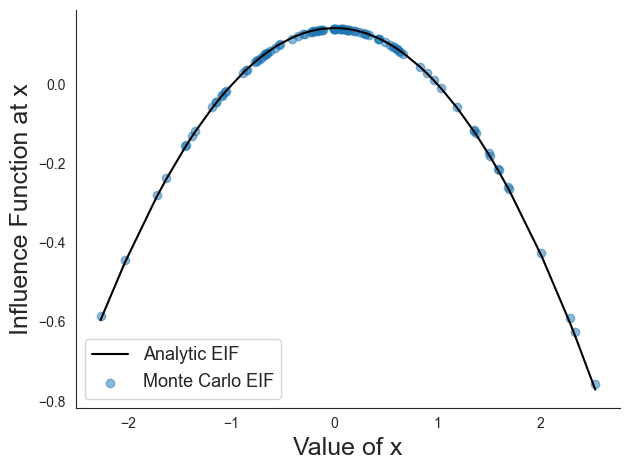

In [9]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True), 
    "sd": torch.tensor(sd_true, requires_grad=True)
}

model = ToyNormal()
guide = MLEGuide(theta_true)

influence = influence_fn(
    functional,
    {'Y': Y_pts},
)(PredictiveModel(model, guide))

with MonteCarloInfluenceEstimator(num_samples_inner=1, num_samples_outer=50000):
    with torch.no_grad():  # Avoids memory leak 
        monte_eif=influence()

# monte_eif = influence_fn(
#     functional, {'Y': Y_pts}, num_samples_outer=50000, num_samples_inner=1
# )(PredictiveModel(model, guide))()

plt.plot(Y_pts, fisher_pointwise, label='Analytic EIF', color='black')
plt.scatter(Y_pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.xlabel('Value of x', fontsize=18)
plt.ylabel('Influence Function at x', fontsize=18)
plt.legend(fontsize=13)
sns.despine()
plt.tight_layout()
plt.savefig("figures/toy_normal_monte_carlo_eif_unknown_var.pdf")

## Uknown Mean, Known SD

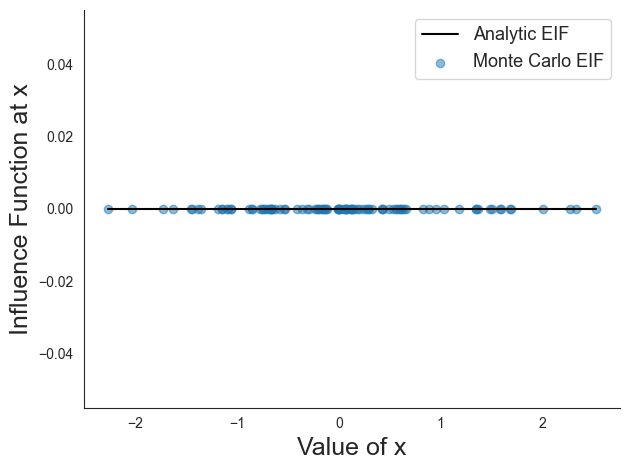

In [10]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True), 
}

model = ToyNormalKnownSD(sd_true)
guide = MLEGuide(theta_true)

influence = influence_fn(
    functional,
    {'Y': Y_pts},
)(PredictiveModel(model, guide))

with MonteCarloInfluenceEstimator(num_samples_inner=1, num_samples_outer=50000):
    with torch.no_grad():  # Avoids memory leak 
        monte_eif=influence()
        
plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label='Analytic EIF', color='black')
plt.scatter(Y_pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.xlabel('Value of x', fontsize=18)
plt.ylabel('Influence Function at x', fontsize=18)
plt.legend(fontsize=13)
sns.despine()
plt.tight_layout()
plt.savefig("figures/toy_normal_monte_carlo_eif_known_var.pdf")

## NP??

In [11]:
N_pts_train = 250

D_pts_train = Predictive(true_model, num_samples=N_pts_train, return_sites=["Y"])()
Y_pts_train = D_pts_train["Y"]
Y_pts_train = torch.sort(Y_pts_train).values

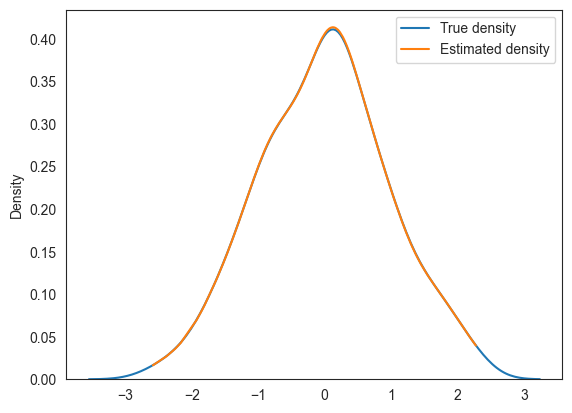

In [12]:
import torch.nn as nn

class KDE(nn.Module):
    """
    A Kernel Density Estimator using a Gaussian kernel.
    """

    def __init__(self, data, bandwidth):
        """
        Initializes the KDE with data and bandwidth.

        :param data: A 1D tensor of data points.
        :param bandwidth: The bandwidth (standard deviation) of the Gaussian kernel.
        """
        super().__init__()
        # Register data as a parameter
        self.data = nn.Parameter(data)
        self.n = len(data)
        # Register bandwidth as a parameter
        self.bandwidth = nn.Parameter(torch.tensor(bandwidth))
        # Use softplus to ensure bandwidth is positive
        self.softplus = nn.Softplus()

    def log_prob(self, x):
        """
        Computes the log probability density at point(s) x.

        :param x: A tensor of points where the density is evaluated.
        :return: A tensor of log probability densities.
        """
        # Ensure bandwidth is positive
        bandwidth = self.softplus(self.bandwidth)
        # print(f'bandwidth: {bandwidth}')
        x = x.unsqueeze(-1)  # Shape: (..., 1)
        data = self.data.unsqueeze(0)  # Shape: (1, n)
        # Compute log probabilities for each data point
        log_probs = dist.Normal(data, bandwidth).log_prob(x)  # Shape: (..., n)
        # Average over all data points
        log_prob = torch.logsumexp(log_probs - torch.log(torch.tensor(self.n, dtype=log_probs.dtype)), dim=-1)
        return log_prob

    def forward(self):
        """
        Generates samples from the KDE.

        :param sample_shape: The desired shape of the sample.
        :return: A tensor of samples.
        """
        bandwidth = self.softplus(self.bandwidth)

        # pyro.sample from a discrete uniform distribution over the data points
        # idx = pyro.sample('idx', dist.Categorical(logits=torch.zeros(self.n)))
        # mu = self.data[idx]
        # y = pyro.sample('Y', dist.Normal(mu, bandwidth))
        
        mixture_dist = dist.MixtureSameFamily(
            mixture_distribution=dist.Categorical(logits=torch.zeros(self.n)),
            component_distribution=dist.Normal(self.data, bandwidth)
        )
        y = pyro.sample('Y', mixture_dist)        
        return y

# Example usage:

bandwidth = -1.0

# Create KDE instance
kde = KDE(Y_pts_train, bandwidth)

# Compute log probability densities
log_probs = kde.log_prob(Y_pts_train)

# Convert to probability densities
probs = log_probs.exp()

sns.kdeplot(Y_pts_train,label='True density')
plt.plot(Y_pts_train.cpu().detach().numpy(), probs.cpu().detach().numpy(), label='Estimated density')
plt.legend()
plt.savefig("figures/toy_normal_kernel_density.pdf")
plt.show()

In [13]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000) # 10000

influence = influence_fn(
    functional,
    {'Y': Y_pts},
)(kde)

with MonteCarloInfluenceEstimator(num_samples_inner=1, num_samples_outer=50000): # 50000
    with torch.no_grad():  # Avoids memory leak 
        kde_monte_eif=influence()

# kde_monte_eif = influence_fn(
#     functional, {'Y': Y_pts}, num_samples_outer=10, num_samples_inner=1
# )(kde)()

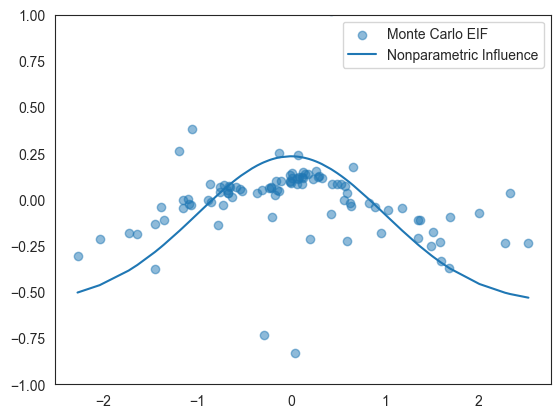

In [15]:
kennedy_pointwise = kennedy_if_analytic(Y_pts, mu_true, sd_true)
fisher_pointwise = fisher_eif_analytic(Y_pts, mu_true, sd_true, False)
tangent_fn_pointwise = kennedy_pointwise - fisher_pointwise

plt.scatter(Y_pts, kde_monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.plot(Y_pts, kennedy_pointwise, label="Nonparametric Influence")
# plt.plot(Y_pts, tangent_fn_pointwise, label="Tangent Nuisance Function")
plt.ylim(-1,1)
plt.legend()
plt.savefig("figures/toy_normal_double_density_eif_np.pdf")
plt.show()